# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2020-2021 учебный год

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2021)


Лектор: Илья Щуров

Семинаристы: Соня Дымченко, Руслан Хайдуров

# Семинар 3

Сегодня мы узнаем

* Как работает метод ближайших соседей, какие у него есть параметры и на что они влияют.
* Что такое кросс-валидация по отложенной выборке

# Метод k ближайших соседей

Метод k ближайших соседей (k nearest neighbours, k-NN) является одним из простейших алгоритмов машинного обучения. Несмотря на свою простоту, k-NN может превзойти более мощные алгоритмы и используется во множестве приложений, таких как экономическое прогнозирование, сжатие данных и генетика. Например, k-NN использовалась в [исследовании](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-S1-S11) по функциональной геномике в 2006 году, где гены определялись на основе их профилей экспрессии.

## Как работает k-NN?

Начнем с введения некоторых определений и обозначений.

* Пусть $x \in X$ — вектор признаков (или атрибутов) объекта. Обычно $X=\mathbb R^d$.
* Под $y$ мы будем подразумевать значение, которое мы хотим научиться предсказывать. Оно может быть числом (тогда говорят о *задаче регрессии*) или элементом конечного множества (*классом* или *меткой*, тогда говорят о *задаче классификации*). Например, предсказать выручку магазина по его месторасположению — это задача регрессии, а определить, болен человек некоторой конкретной болезнью или нет — задача классификации.

k-NN входит в число **supervised** алгоритмов или алгоритмов «обучения с учителем».
Это означает, что нам предоставляется набор данных $(x_1, y_1), \ldots, (x_n, y_n)$, в котором приведены признаки и верные ответы для $n$ каких-то объектов. Целью является на основе предоставляемой выборки найти связь между $x$ и $y$, то есть восстановить функцию $h: X \rightarrow Y$. Имея такую функцию, мы можем предсказать $y$ по имеющемуся наблюдению $x$.

Для нового объекта с вектором признаков $x_{new}$ алгоритм k-NN находит $k$ ближайших к $x_{new}$ точек среди $x_1, \ldots, x_n$. Пусть они имеют индексы $i_1, \ldots, i_k$. Для задачи регрессии в качестве $h(x)$ используется среднее соответствующих значений $y$, то есть

$$h(x)=\frac{1}{k}\sum_{i=1}^k y_{i_k}.$$

Для задачи классификации в качестве $h(x)$ используется то значение $y$, которое встречается среди $y_{i_1}, \ldots, y_{i_k}$ чаще всего (если таких значений несколько, выбирается какое-то одно из них — например, самое маленькое для какого-то порядка на классах).

## Реализация k-NN вручную

Чтобы лучше понять, как работает kNN, реализуем его «вручную». Наша реализация будет довольно неэффективной — для реальной работы мы будем использовать реализацию в библиотеке scikit-learn, которая использует хитрые структуры данных для быстрого поиска ближайшего соседа. Мы же будем банально сортировать все элементы по близости к новому и выбирать k самых близких. Это дико неэффективно (в серьёзных приложениях используются [k-d деревья](https://en.wikipedia.org/wiki/K-d_tree), но зато понятно, как работает.

In [1]:
import numpy as np

### Вычисляем расстояние от новой точки до остальных точек в нашей выборке

Пусть $d=2$ и у нас есть три объекта в обучающей выборке. Зададим их как-нибудь.

In [102]:
x_train = np.array([[2, 3],
                    [1, 5],
                    [0, 0]])
y_train = np.array([10, 20, 30])

Есть также новый объект, для которого мы хотим построить предсказание.

In [103]:
x_new = np.array([1, 2])

Во-первых, нам нужно найти расстояния между `x_new` и остальными объектами в `x_train`. Проще всего это сделать так: найти их разности, затем найти нормы этих разностей. Получатся квадраты расстояний, но нам нужно их просто сравнить.

Чтобы найти разность между `x_new` и остальными объектами в `x_train`, достаточно просто вычесть `x_new` из `x_train`:

In [104]:
x_new - x_train

array([[-1, -1],
       [ 0, -3],
       [ 1,  2]])

Почему это работает? Благодаря broadcasting rules.

In [6]:
x_train.shape

(3, 2)

In [5]:
x_new.shape

(2,)

Если разместить shape каждого массива, выровняв по правому краю, видно, что выполняются условия совместимости: под каждым числом сверху находится либо такое же число снизу, либо 1 (в данном случае такого нет), либо пустота. Это означает, что можно превратить вектор (одномерный массив) `x_new` в матрицу с shape (3, 2) путём «размножения» этого вектора:

```
3, 2        3, 2
   2  --->  3, 2
```

```
np.array([1, 2]) ---> np.array([[1, 2]
                                [1, 2]
                                [1, 2]])
```
после этого вычесть из исходной матрицы новую. Так и работает broadcasting и это ровно то, что нам нужно.

Осталось вычислить нормы разностей.

In [105]:
np.linalg.norm(x_new - x_train)

4.0

Не получилось, по умолчанию `np.linalg.norm` будет трактовать наши матрицы как точки в шестимерном пространстве. Чтобы эта функция работала с каждым вектором отдельно, нужно добавить параметр `axis`.

In [106]:
np.linalg.norm(x_new - x_train, axis=1)

array([1.41421356, 3.        , 2.23606798])

`axis=1` указывает на то, что в ходе вычислений в самом внутреннем цикле будет меняться значение индекса, соответствующего оси с номером 1, то есть второй, то есть столбцов.

Итак:

In [107]:
distances_sq = np.linalg.norm(x_new - x_train, axis=1)

### Выбор k ближайших соседей

Воспользуемся функцией `np.argsort`. Она выдаёт набор индексов, такой, что если брать элементы с этими индексами, то массив окажется отсортированным. Например.

In [108]:
np.argsort(np.array([4, 100, 12, 3, 2, 10]))

array([4, 3, 0, 5, 2, 1])

Самый маленький элемент имеент индекс 4, следующий по малости — 3, потом 0 и т.д.

Если использовать массив индексов в качестве аргумента квадратных скобок, будут выбраны элементы, соответствующие этим индексам.

In [109]:
arr = np.array([0, 10, 20, 30, 40])
arr[np.array([1, 0, 1, 2])]

array([10,  0, 10, 20])

Получаем для нашей задачи:

In [118]:
k = 2
indexes_sorted = np.argsort(distances_sq)
y_train[indexes_sorted[:k]].mean()

20.0

In [119]:
def kNN_regression(x_train, y_train, x_new, k=1):
    """
    x_train is np.array with shape (n, d) (matrix with n rows, d columns)
    y_train is np.array with shape (n, ) (1-dimensional array with n elements)
    x_new is np.array with shape (d,) (1-dimensional array with d elements)
    """
    distances_sq = np.linalg.norm(x_train - x_new, axis=1)
    indexes_sorted = np.argsort(distances_sq)
    return y_train[indexes_sorted[:k]].mean()

In [120]:
kNN_regression(x_train = np.array([[12, 3],
                                   [4, 5],
                                   [1, 5]]),
               y_train = np.array([10, 20, 30]),
               x_new = np.array([11, 4]),
               k = 2)

15.0

## Синтезированные данные
Посмотрим, как работает k-NN на примере синтезированных данных. Пусть реальная зависимость $y$ и $x$ задаётся правилом $y=x^2+\varepsilon$, где $\varepsilon$ — некоторый шум с нулевым матожиданием.

Точнее, мы будем рассматривать следующую модель:

\begin{gather}
X \sim Uniform(-1, 1);\\
\varepsilon \sim \mathcal N(0, \varepsilon_0^2)\\
Y = X^2 + \varepsilon,
\end{gather}

где $Uniform(-1, 1)$ — равномерное распределение на отрезке $[-1, 1]$, переменные $X$ и $\varepsilon$ независимы.

In [121]:
n = 10
np.random.uniform(low=-1, high=1, size=(n, 1))

array([[-0.49069251],
       [-0.91693958],
       [-0.01299215],
       [ 0.92879661],
       [ 0.33796647],
       [ 0.46056795],
       [ 0.90023528],
       [-0.4392232 ],
       [-0.74121161],
       [-0.77583399]])

In [23]:
def f(x):
    return x ** 2

# Y | X = X^2 + \eps

def make_data(n, eps0):
    x = np.random.uniform(low=-1, high=1, size=(n, 1))
    eps = np.random.normal(scale=eps0, size=(n, 1))
    
    y = (x ** 2 + eps)[:, 0]
    # чтобы Y был одномерным, выбрали первый (он же единственный) столбец
    # с помощью [:, 0]

    return x, y

Как обсуждалось на лекции, наилучшим предсказанием $y$ для данного $x$ с точки зрения минимизации ожидаемой ошибки для квадратичной функции потерь является условное матожидание $E[Y\mid X=x]$. Для нашей модели

$$E[Y\mid X=x]=x^2.$$

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

### Эффект от изменения $k$ 

Посмотрим, как работает k-NN для наших данных.

In [34]:
X, Y = make_data(30, 0.1)

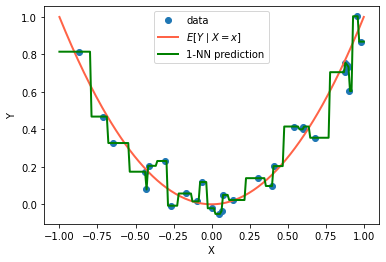

In [35]:
def plot_kNN(X, Y, k, **kwargs):
    plt.plot(X[:, 0], Y, 'o', label="data", **kwargs)
    x_grid = np.linspace(-1, 1, 200)
    plt.plot(x_grid, f(x_grid), color='tomato', lw=2, label="$E[Y\mid X=x]$")
    plt.plot(x_grid, [kNN_regression(X, Y, x_new, k) for x_new in x_grid], 
             'g-', label="{}-NN prediction".format(k), lw=2)
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
plot_kNN(X, Y, 1)

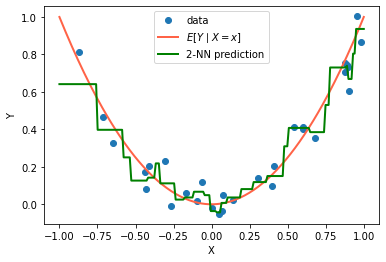

In [36]:
plot_kNN(X, Y, 2)

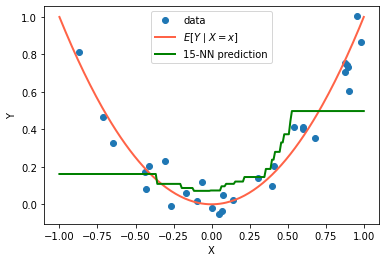

In [37]:
plot_kNN(X, Y, 15)

Что будет, если увеличить количество данных?

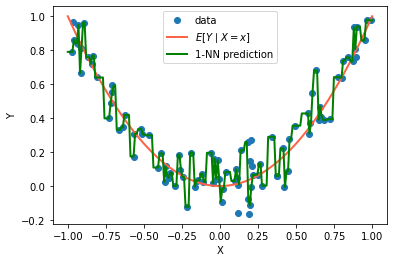

In [38]:
X, Y = make_data(100, 0.1)
plot_kNN(X, Y, 1)

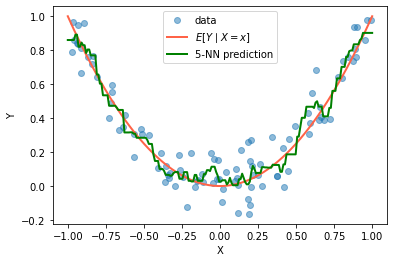

In [39]:
plot_kNN(X, Y, 5, alpha=0.5)

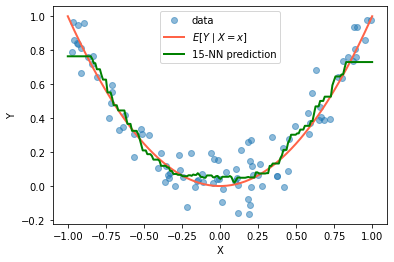

In [40]:
plot_kNN(X, Y, 15, alpha=0.5)

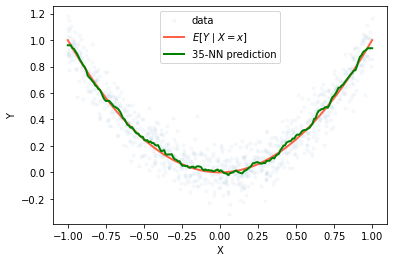

In [41]:
X, Y = make_data(1000, 0.1)
plot_kNN(X, Y, 35, markersize=3, alpha=0.03)

**Теорема**. Если $f(x)=E[Y\mid X=x]$ является непрерывной функцией от $x$, при некоторых дополнительных условиях, k-NN-регрессия стремится к $f(x)$ при $k, N \to \infty$, т.ч. $k/N\to 0$.

**Основная идея:** если данных очень много, то можно выбрать такое большое $k$, которое было бы при этом мало по сравнению с $N$. При этом $k$ ближайших соседей для точки $x_{new}$ будут лежать очень близко к ней, и, за счёт того, что $k$ большое, k-NN оценка будет достаточно близкой к истинному матожиданию $f(x_{new})$.

### Отступление: передача именованных параметров с помощью `**`

In [122]:
def foo(x, y):
    print(f"x = {x}, y = {y}")

In [44]:
foo(3, 4)

x = 3, y = 4


In [45]:
foo(x=2, y=3)

x = 2, y = 3


In [46]:
params = {'x': 2, 'y': 3}

In [47]:
foo(x=params['x'], y=params['y'])

x = 2, y = 3


Вот так можно сделать это коротко:

In [48]:
foo(**params)

x = 2, y = 3


### Оценка EPE

$$EPE(f) \approx \frac{1}{n} \sum_{i=1}^n L(y^{new}_i, f(x^{new}_i))$$

In [123]:
def EPE(f, L, make_data, data_args, f_args):
    X_new, Y_new = make_data(**data_args)
    return sum(L(y_new, f(x_new, **f_args)) 
                for x_new, y_new in zip(X_new, Y_new)) / len(X_new)

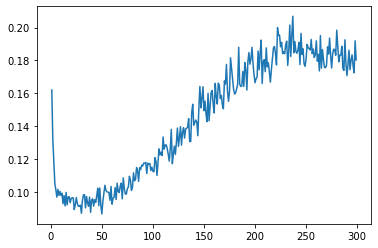

In [156]:
def f(x, k):
    return kNN_regression(X, Y, x, k)

def L(y, y_hat):
    return (y - y_hat) ** 2

n_train = 300
eps0 = 0.3

X, Y = make_data(n=n_train, eps0=eps0)

k = range(1, n_train)
plt.plot(k, 
         [EPE(f, L, make_data, data_args={'n': 1000, 'eps0': eps0}, f_args={'k': k_})
          for k_ in k])

### Кросс-валидация: hold-out выборка

In [150]:
X, Y = make_data(n=n_train, eps0=eps0)

In [157]:
X_train = X[:n_train * 2 // 3]
Y_train = Y[:n_train * 2 // 3]

X_test = X[n_train * 2 // 3:]
Y_test = Y[n_train * 2 // 3:]

In [158]:
def kv_loss(k):
    return sum(L(y_new, kNN_regression(X_train, Y_train, x_new, k=k)) 
               for x_new, y_new in zip(X_test, Y_test)) / len(X_test)

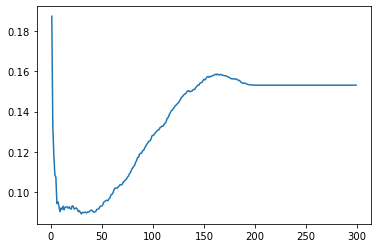

In [159]:
k = range(1, 300)
plt.plot(k, [kv_score(k_) for k_ in k])

### kNN для задачи классификации
Напишите функцию `kNN_classifier(x_train, y_train, x_new, k=1)` по аналогии с `kNN_regression`. Вместо взятия среднего нужно выбрать значение $y$, которое встречается среди $k$ ближайших соседей чаще всего. (Подсказка: оно называется *модой*.)

In [0]:
def kNN_classifier(x_train, y_train, x_new, k=1):
    # YOUR CODE HERE
    pass